### Import Library

In [ ]:
import numpy as np
import pandas as pd

import pickle

import warnings
warnings.filterwarnings("ignore")

from sklearn.metrics import mean_squared_error

from matplotlib.pyplot import figure
import matplotlib.pyplot as plt

In [ ]:
import sys
sys.path.append('../')

In [ ]:
from importlib import reload

from custom_function import minimalSARIMAX

reload(minimalSARIMAX)

from custom_function.minimalSARIMAX import MinimalSARIMAX

### Import Train and Test sets

In [5]:
train_set = pd.read_csv('6Hsampled_data_set/KKC/train_set.csv')
train_set['WindDirSin'] = np.sin(train_set['WindDir'])*10 + 10
train_set['WindDirCos'] = np.cos(train_set['WindDir'])*10 + 10
train_set['Time'] = pd.to_datetime(train_set['Time'])
train_set = train_set.set_index('Time')

valid_set = pd.read_csv('6Hsampled_data_set/KKC/valid_set.csv')
valid_set['WindDirSin'] = np.sin(valid_set['WindDir'])*10 + 10
valid_set['WindDirCos'] = np.cos(valid_set['WindDir'])*10 + 10
valid_set['Time'] = pd.to_datetime(valid_set['Time'])
valid_set = valid_set.set_index('Time')

test_set = pd.read_csv('6Hsampled_data_set/KKC/test_set.csv')
test_set['WindDirSin'] = np.sin(test_set['WindDir'])*10 + 10
test_set['WindDirCos'] = np.cos(test_set['WindDir'])*10 + 10
test_set['Time'] = pd.to_datetime(test_set['Time'])
test_set = test_set.set_index('Time')

### Tuning Parameters

In [6]:
order = (2, 0, 1)
seasonal_order = (0, 1, 0, 1461)

exog_order = {}
exog_order['Temp'] = (2, 0, 0)
exog_order['WindSpeed'] = (1, 0, 1)
exog_order['WindDirSin'] = (2, 0, 1)
exog_order['WindDirCos'] = (1, 1, 2)

exog_seasonal_order = {}
exog_seasonal_order['Temp'] = (0, 1, 0, 1461)
exog_seasonal_order['WindSpeed'] = (1, 1, 1, 1461)
exog_seasonal_order['WindDirSin'] = (0, 1, 0, 1461)
exog_seasonal_order['WindDirCos'] = (1, 1, 1, 1461)

exog_columns = ['Temp', 'WindSpeed', 'WindDirSin', 'WindDirCos']

### Initialize model

In [7]:
model = {}
model_exog = {}

model = MinimalSARIMAX(train_set[['PM25']],
                          order,
                          seasonal_order,
                          exog=train_set[exog_columns])
    
model_exog = {}
for exog in exog_columns:
    model_exog[exog] = MinimalSARIMAX(train_set[[exog]],
                                      exog_order[exog],
                                      exog_seasonal_order[exog])

### Train exogenous models

In [8]:
model.fit(lr=1e-6, lr_decay=0.999 ,verbose=0)

for exog in exog_columns:
        model_exog[exog].fit(lr=1e-6, lr_decay=0.999, verbose=0)
        n_iter = 1
        if exog=='WindSpeed': n_iter=10
        _ = model_exog[exog].predict_step(train_set[[exog]],
                                          valid_set[[exog]], 
                                          lr=np.array([1e-6]), lr_decay=0.999875, lr_decay_iter=0.95,
                                          step=12, n_iter=n_iter, learn=True, verbose=1)

100%|██████████| 4383/4383 [05:09<00:00, 14.14it/s]


ITER#0  RMSE:8.727868135105195


100%|██████████| 4383/4383 [04:55<00:00, 14.82it/s]


ITER#0  RMSE:15.642863957254091


100%|██████████| 4383/4383 [05:01<00:00, 14.55it/s]


ITER#1  RMSE:14.938046447540769


100%|██████████| 4383/4383 [04:52<00:00, 15.00it/s]


ITER#2  RMSE:14.809976270978673


100%|██████████| 4383/4383 [04:28<00:00, 16.35it/s]


ITER#3  RMSE:14.677455966282256


100%|██████████| 4383/4383 [04:25<00:00, 16.50it/s]


ITER#4  RMSE:14.538569543269091


100%|██████████| 4383/4383 [04:27<00:00, 16.36it/s]


ITER#5  RMSE:14.38863494924408


100%|██████████| 4383/4383 [04:23<00:00, 16.63it/s]


ITER#6  RMSE:14.228389300392513


100%|██████████| 4383/4383 [04:05<00:00, 17.86it/s]


ITER#7  RMSE:14.054288479244997


100%|██████████| 4383/4383 [04:51<00:00, 15.05it/s]


ITER#8  RMSE:13.86577204605703


100%|██████████| 4383/4383 [04:55<00:00, 14.84it/s]


ITER#9  RMSE:13.660787241277832


100%|██████████| 4383/4383 [04:44<00:00, 15.39it/s]


ITER#0  RMSE:10.099145098072617


100%|██████████| 4383/4383 [05:01<00:00, 14.56it/s]

ITER#0  RMSE:9.95002936669748


### Train PM2.5 model with exogenous models

In [9]:
Result_train = model.predict_step(train_set[['PM25']],
                                  valid_set[['PM25']], 
                                  val_X_exog=train_set[exog_columns],
                                  y_exog=valid_set[exog_columns], 
                                  model_exog=model_exog,
                                  lr=np.array([5e-6, 5e-7, 5e-7, 5e-7, 5e-7]), lr_decay=0.999, lr_decay_iter=0.95,
                                  step=12, n_iter=10, learn=True, verbose=1)

train_pred_sav, val1_pred_sav, Error_save = Result_train

100%|██████████| 4383/4383 [17:50<00:00,  4.09it/s]


ITER#0  RMSE:13.147013623885103


100%|██████████| 4383/4383 [18:46<00:00,  3.89it/s]


ITER#1  RMSE:12.662616576114738


100%|██████████| 4383/4383 [18:47<00:00,  3.89it/s]


ITER#2  RMSE:11.431936190493872


100%|██████████| 4383/4383 [18:33<00:00,  3.94it/s]


ITER#3  RMSE:10.6105105762005


100%|██████████| 4383/4383 [16:59<00:00,  4.30it/s]


ITER#4  RMSE:10.295754612263096


100%|██████████| 4383/4383 [17:28<00:00,  4.18it/s]


ITER#5  RMSE:10.240398062275256


100%|██████████| 4383/4383 [16:49<00:00,  4.34it/s]


ITER#6  RMSE:10.239607943982499


100%|██████████| 4383/4383 [15:30<00:00,  4.71it/s]


ITER#7  RMSE:10.239690199436051


100%|██████████| 4383/4383 [15:28<00:00,  4.72it/s]


ITER#8  RMSE:10.236524396985153


100%|██████████| 4383/4383 [14:54<00:00,  4.90it/s]

ITER#9  RMSE:10.231874035723967


In [10]:
model.params

{'p': array([0.46236402, 0.50022311]),
 'pX': array([ 0.05633292,  0.01503314, -0.02251706, -0.00016889]),
 'd': array([0.]),
 'q': array([0.22871664]),
 'P': array([0.]),
 'D': array([0.00867405]),
 'Q': array([0.]),
 'c': 0.10803105567777786}

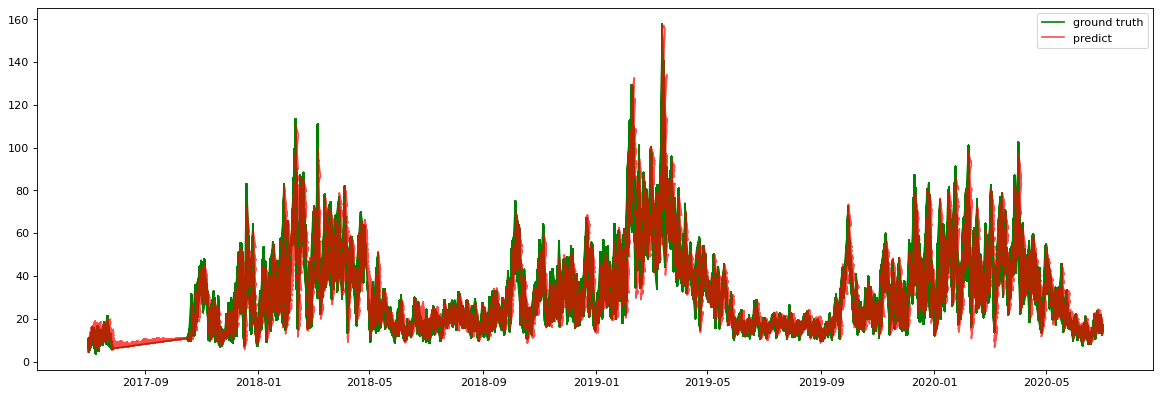

In [11]:
train_X = pd.concat([train_pred_sav, val1_pred_sav])
train_X = train_X.set_index('Time')

plt.figure(num=None, figsize=(18, 6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(train_X['Actual'], color='g', label='ground truth')
plt.plot(train_X['Predict'], alpha=.7, color='r', label='predict')
plt.legend(loc="upper right")

#### Dump PM2.5 model and exog models

In [12]:
with open('./model_save/khonkaen/model_kkc.model',"wb") as f:
    pickle.dump(model, f)

with open('./model_save/khonkaen/model_kkc_exog.model',"wb") as f:
    pickle.dump(model_exog, f)

#### Load PM2.5 model and exog models

In [13]:
model = pickle.load(open('./model_save/khonkaen/model_kkc.model', 'rb'))
model_exog = pickle.load(open('./model_save/khonkaen/model_kkc_exog.model', 'rb'))

### Predict on test set

In [14]:
Result_test = model.predict_step(valid_set[['PM25']],
                                 test_set[['PM25']], 
                                 val_X_exog=valid_set[exog_columns],
                                 y_exog=test_set[exog_columns], 
                                 model_exog=model_exog,
                                 lr=np.array([5e-7, 5e-7, 5e-7, 5e-7, 5e-7]), lr_decay=0.999875,
                                 step=12, n_iter=1, learn=True, verbose=1)	

val2_pred_sav, test_pred_sav, Error_save = Result_test

100%|██████████| 2779/2779 [09:28<00:00,  4.89it/s]

ITER#0  RMSE:9.50776518756481


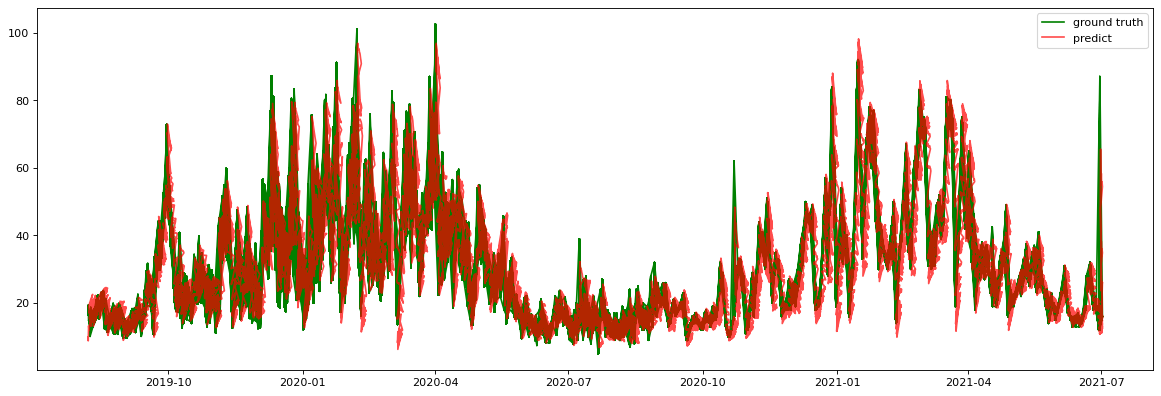

In [15]:
test_X = pd.concat([val2_pred_sav, test_pred_sav])
test_X = test_X.set_index('Time')

plt.figure(num=None, figsize=(18, 6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(test_X['Actual'], color='g', label='ground truth')
plt.plot(test_X['Predict'], alpha=.7, color='r', label='predict')
plt.legend(loc="upper right")

In [16]:
test_pred_sav.to_csv('../answer_dataset/pred_and_actual/y_pred_sav_KKC.csv')